<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip

In [0]:
import tensorflow as tf
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [0]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

training_images_file = 'ODIR-5K/Training_Images'
testing_images_file = 'ODIR-5K/Testing_Images'
labels_file = 'ODIR-5K/data.xlsx'

In [6]:
#load labels to pandas
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display

labels = pd.read_excel(labels_file, index_col=0) 
labels['Left-Diagnostic Keywords'][0]

'cataract'

In [0]:
import glob
all_paths = []
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  all_paths.append(element)

paths = []

for u_id in labels.index:
  labelL = ""
  labelR = ""
  if labels['Left-Diagnostic Keywords'][u_id] == "normal fundus":
    labelL = "N"
  elif labels['D'][u_id] == 1:
    labelL = "D"
  elif labels['G'][u_id] == 1:
    labelL = "G"
  elif labels['C'][u_id] == 1:
    labelL = "C"
  elif labels['A'][u_id] == 1:
    labelL = "A"
  elif labels['H'][u_id] == 1:
    labelL = "H"
  elif labels['M'][u_id] == 1:
    labelL = "M"
  elif labels['O'][u_id] == 1:
    labelL = "O"

  if "ODIR-5K/Training Images/"+str(labels['Left-Fundus'][u_id]) in all_paths:
    filename = str(labels['Left-Fundus'][u_id]).split(".")
    os.rename("ODIR-5K/Training Images/"+str(labels['Left-Fundus'][u_id]), "ODIR-5K/Training Images/"+filename[0]+"-"+labelL+".jpg")
    paths.append("ODIR-5K/Training Images/"+str(labels['Left-Fundus'][u_id])+"/"+labelL)
  #labels_dictionary[str(labels['Left-Fundus'][u_id])] = labelL

  if labels['Right-Diagnostic Keywords'][u_id] == "normal fundus":
    labelR = "N"
  elif labels['D'][u_id] == 1:
    labelR = "D"
  elif labels['G'][u_id] == 1:
    labelR = "G"
  elif labels['C'][u_id] == 1:
    labelR = "C"
  elif labels['A'][u_id] == 1:
    labelR = "A"
  elif labels['H'][u_id] == 1:
    labelR = "H"
  elif labels['M'][u_id] == 1:
    labelR = "M"
  elif labels['O'][u_id] == 1:
    labelR = "O"
  
  if "ODIR-5K/Training Images/"+str(labels['Right-Fundus'][u_id]) in all_paths:
    filename = str(labels['Right-Fundus'][u_id]).split(".")
    os.rename("ODIR-5K/Training Images/"+str(labels['Right-Fundus'][u_id]), "ODIR-5K/Training Images/"+filename[0]+"-"+labelR+".jpg")
    paths.append("ODIR-5K/Training Images/"+str(labels['Right-Fundus'][u_id])+"/"+labelR)

  #add_element(labels_dictionary, str(labels['Right-Fundus'][u_id]), labelR)
  #labels_dictionary[str(labels['Right-Fundus'][u_id])] = labelR

In [0]:
list_ds = tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")

In [56]:
for f in list_ds.take(5):
  print(f.numpy())

b'ODIR-5K/Training Images/4029_left-D.jpg'
b'ODIR-5K/Training Images/4234_left-D.jpg'
b'ODIR-5K/Training Images/2533_left-N.jpg'
b'ODIR-5K/Training Images/2358_left-.jpg'
b'ODIR-5K/Training Images/2485_right-N.jpg'


In [0]:
def get_label(name):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]


In [0]:
def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  #name = get_name(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  #img = tf.io.read_file(file_path)
  #img = decode_img(img)
  return label

In [47]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
print(type(list_ds))
AUTOTUNE = tf.data.experimental.AUTOTUNE
named_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


NameError: ignored

In [123]:
for image, name, label in named_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("name: ", name.numpy())
  print('label: ', label.numpy())

Image shape:  (224, 224, 3)
name:  b'1285_left.jpg'
label:  b'D'


In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(named_ds)

image_batch, name_batch, label_batch = next(iter(train_ds))

In [0]:
def show_batch(image_batch, name_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(label_batch[n], loc='center')
      plt.title(name_batch[n], loc='left')
      plt.axis('off')

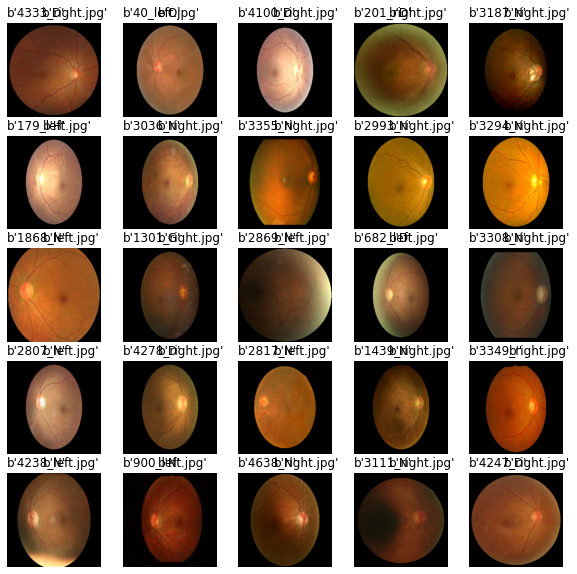

In [134]:
show_batch(image_batch.numpy(), name_batch.numpy(), label_batch.numpy())

In [0]:
!rm -rf ODIR-5K/